# 6. Sparse Kernel Machines

### *Table of Contents*

* 7.1 [Maximum Margin Classifiers](#7.1-Maximum-Margin-Classifiers)
    * 7.1.1 [Overlapping class distributions](#7.1.1-Overlapping-class-distributions)
    * 7.1.2 [Relation to logistic regression](#7.1.2-Relation-to-logistic-regression)
    * 7.1.3 [Multiclass SVM](#7.1.3-Multiclass-SVM)
    * 7.1.4 [SVMs for regression](#7.1.4-SVMs-for-regression)
* 7.2 [Relevance Vector Machines](#7.2-Relevance-Vector-Machines)
    * 7.2.1 [RVM for regression](#7.2.1-RVM-for-regression)
    * 7.2.3 [RVM for classification](#7.2.3-RVM-for-classification)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from prml.kernel import SupportVectorClassifier, SupportVectorRegressor, RBF, RelevanceVectorRegressor
from prml.datasets import generate_toy_data

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide="ignore", invalid="ignore")

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

# Enable autoreload all modules before executing code
%reload_ext autoreload
%autoreload 2

One significant limitation of many kernel-based methods (see [Chapter 6](ch6_kernel_methods.ipynb)) is that the kernel function $k(\mathbf{x}_n, \mathbf{x}_m)$ must be evaluated for all possible pairs $\mathbf{x}_n$ and $\mathbf{x}_m$ of training data points. This can be computationally infeasible during training (does not scale to large datasets) and also leads to excessive computation overhead when making predictions for new data points.

On the other hand, there are kernel-based algorithms that yield *sparse* solutions (maintain a subset of training data points), so that predictions depend only on the kernel fuction evaluated at the subset of these training data points. We shall look into *support vector machine* (SVM), which are easy to train using convex optimization, but does not provide posterior probabilities. An alternative sparse kernel technique, known as *relevance vector machine* (RVM), is based on Bayesian formulation and provides posterior probabilistic outputs. Additionally, RVM has much sparser solutions than SVM, but it is slower to optimize.

## 7.1 Maximum Margin Classifiers

Consider the classification problem using linear models of the form,

$$
y(\mathbf{x}) = \mathbf{w}^T\boldsymbol\phi(\mathbf{x}) + b
$$

The training data set comprises $N$ input vectors $\mathbf{x}_1,\dots,\mathbf{x}_N$ and corresponding target values $t_1,\dots,t_N$, where $t_n\in\{−1, 1\}$.

> We assume for the moment that the training dataset is linearly separable in feature space defined by $\boldsymbol\phi$, so that there exists at least one choice of parameters such $y(\mathbf{x}_n)>0$ for points having $t_n=+1$ and $y(\mathbf{x}_n)<0$ for points having $t_n=−1$. In general, so that $t_ny(\mathbf{x}_n) > 0$ for all training data points.

The support vector machine approaches this problem through the concept of the margin, which is defined to be the smallest distance between the decision boundary and any of the samples. In support vector machine the decision boundary is chosen to be the one for which the margin is maximized. Recall that the perpendicular distance of a point $\mathbf{x}_n$ from the decision boundary, defined by $y(\mathbf{x}) = 0$, is given by $\frac{y(\mathbf{x})}{||\mathbf{w}||_2}$. Since we are only interested in solutions for which all data points are correctly classified, so that $t_ny(\mathbf{x}_n) > 0$ for all $n$. Thus, the distance of a point $\mathbf{x}_n$ to the decision surface is given by,

$$
d_s(\mathbf{x}_n) = \frac{t_ny(\mathbf{x}_n)}{||\mathbf{w}||_2} = \frac{t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b)}{||\mathbf{w}||_2}
$$

Thus, the margin is defined by the closest point $\mathbf{x}_n$ from the training data points. SVM goal is to optimize the parameters of $y$ in order to maximize the margin or the distance of the closest point. Therefore, the maximum margin solution is found by solving,

$$
\argmax_{\mathbf{w}, b} \Bigg\{\ \min_n d_s(\mathbf{x}_n) \Bigg\} \overset{(7.2)}{=} 
\argmax_{\mathbf{w}, b} \Bigg\{\ \min_n\Bigg[ \frac{t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b)}{||\mathbf{w}||_2} \Bigg] \Bigg\} =
\argmax_{\mathbf{w}, b} \Bigg\{\ \frac{1}{||\mathbf{w}||_2} \min_n\Bigg[ t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) \Bigg] \Bigg\}
$$

The figure on the left depicts the margin as the distance between the decision boundary and the closest data point. On the right, the margin is maximized leadning to a particular choice of the decision boundary (determined by the parameters $\mathbf{w}$ and b). The subset of data points determining the location of the optimized boundary are called *support vectors*.

<img src="../images/fg7_1a.png" width="400">
<img src="../images/fg7_1b.png" width="400"> 

A direct solution of the above optimization problem is very complex, but there is an equivalent problem that is much easier to solve. Note that the rescaling $\mathbf{w} \mapsto \kappa\mathbf{w}$ and $b \mapsto \kappa b$, does not affect the distance from any point $\mathbf{x}_n$ to the decision surface,

$$
\frac{t_n(\kappa\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + \kappa b)}{||\kappa\mathbf{w}||_2} = \frac{t_n\kappa(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b)}{\kappa||\mathbf{w}||_2} =
\frac{t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b)}{||\mathbf{w}||_2}
$$

Therefore, we can set $t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) = 1$, for the point closest to the surface, which implies that all data points should satisfy the constraints $t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) \geq 1$. Data points for which the equality holds, the constraints are said to be *active*, whereas for the remainder they are said to be *inactive*.

Thus, the reformulated optimization problem simply requires that we maximize $1/||\mathbf{w}||$ or equivalently to minimizing $||\mathbf{w}||_2^2$, 

$$
\begin{aligned}
& \argmin_{\mathbf{w}, b}\frac{1}{2}||\mathbf{w}||_2^2 \\
& \text{subject to} \qquad t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) \geq 1
\end{aligned}
$$

This is a *quadratic programming* problem in which we are trying to minimize a quadratic function subject to a set of linear inequality constraints. In order to solve this constrained optimization problem, we introduce Lagrange multipliers $a_n \geq 0$ (one for each constraint), giving the Lagrangian function,

$$
L(\mathbf{w}, b, \mathbf{a}) = \frac{1}{2}||\mathbf{w}||_2^2 - \sum_{n=1}^N a_n \{t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) - 1\}
$$

Setting the derivatives of $L$ with respect to $\mathbf{w}$ and $b$ equal to zero, we obtain,

$$
\begin{aligned}
dL_{\mathbf{w}} = 0 &\Leftrightarrow \mathbf{w} - \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n) = 0 \\
&\Leftrightarrow \mathbf{w} = \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n)
\end{aligned}
$$

and

$$
dL_{b} = 0 \Leftrightarrow \sum_{n=1}^N a_n t_n = 0
$$

Eliminating $\mathbf{w}$ and $b$ by substituting these conditions back to $L(\mathbf{w}, b, \mathbf{a})$, gives the dual representation of the maximum margin problem,

$$
\begin{aligned}
\tilde{L}(\mathbf{a}) &= \frac{1}{2} \Bigg< \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n), \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n) \Bigg>
- \sum_{n=1}^N a_n \Bigg\{t_n \Big(\sum_{m=1}^N a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T\boldsymbol\phi(\mathbf{x}_n) + b \Big) - 1 \Bigg\} \\
&= \frac{1}{2} \Bigg< \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n), \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n) \Bigg>
- \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T \boldsymbol\phi(\mathbf{x}_n)
- b\sum_{n=1}^N a_n t_n
+ \sum_{n=1}^N a_n \\
&\overset{(7.9)}{=} \frac{1}{2} \Bigg< \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n), \sum_{n=1}^N a_n t_n \boldsymbol\phi(\mathbf{x}_n) \Bigg>
- \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T \boldsymbol\phi(\mathbf{x}_n)
+ \sum_{n=1}^N a_n \\
&= \frac{1}{2} \sum_{n=1}^N a_n t_n \sum_{m=1}^N a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T\boldsymbol\phi(\mathbf{x}_n)
- \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T \boldsymbol\phi(\mathbf{x}_n)
+ \sum_{n=1}^N a_n \\
&= \sum_{n=1}^N a_n - \frac{1}{2} \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m \boldsymbol\phi(\mathbf{x}_m)^T \boldsymbol\phi(\mathbf{x}_n)
\end{aligned}
$$

or

$$
\tilde{L}(\mathbf{a}) = \sum_{n=1}^N a_n - \frac{1}{2} \sum_{n=1}^N\sum_{m=1}^N a_n t_n a_m t_m k(\mathbf{x}_n, \mathbf{x}_m)
$$

subject to the constraints,

$$
\begin{aligned}
& a_n \geq 0 \\
\sum_{n=1}^N & a_nt_n = 0
\end{aligned}
$$

In order to classify new data points, we evaluate the sign of $y(\mathbf{x})$, which can be expressed in terms of the parameters $\mathbf{a}$ and the kernel function by substituting for $\mathbf{w}$ to give,

$$
y(\mathbf{x}) = \mathbf{w}^T\boldsymbol\phi(\mathbf{x}) + b = \sum_{n=1}^N a_nt_n\boldsymbol\phi(\mathbf{x}_n)^T\boldsymbol\phi(\mathbf{x}) + b =
\sum_{n=1}^N a_nt_nk(\mathbf{x}_n,\mathbf{x}) + b
$$

> **NOTE**: Any data point for which $a_n=0$ plays no role in making predictions. The remaining data points (where $a_n > 0$) are called support vectors, and because they satisfy $t_ny(\mathbf{x}_n) = 1$, they correspond to points that lie on the maximum margin hyperplanes in feature space. This property is central to the practical applicability of sparse kernel machines. Once the model is trained, a significant proportion of the data points can be discarded, since only the support vectors are required for making predictions.

Having found values for $\mathbf{a}$, we can then determine the value of the threshold parameter $b$ by noting that support vectors satisfy $t_ny(\mathbf{x}_n) = 1$, thus,

$$
\begin{aligned}
t_ny(\mathbf{x}_n) = 1 & \Leftrightarrow t_n \Big( \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n) + b \Big) = 1 \\
& \overset{\times t_n}{\Leftrightarrow} t_n^2 \Big( \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n) + b \Big) = t_n \\
& \overset{t_n^2=1}{\Leftrightarrow} \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n) + b = t_n \\
& \Leftrightarrow b = t_n - \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n)
\end{aligned}
$$

Although the value of $b$ may be found using any support vector $\mathbf{x}_n$, a more numerically stable solution is obtained by taking the average over all support vectors,

$$
b = \frac{1}{N_\mathcal{S}} \sum_{n\in\mathcal{S}} \Big( t_n - \sum_{m\in\mathcal{S}} a_mt_mk(\mathbf{x}_m,\mathbf{x}_n) \Big)
$$

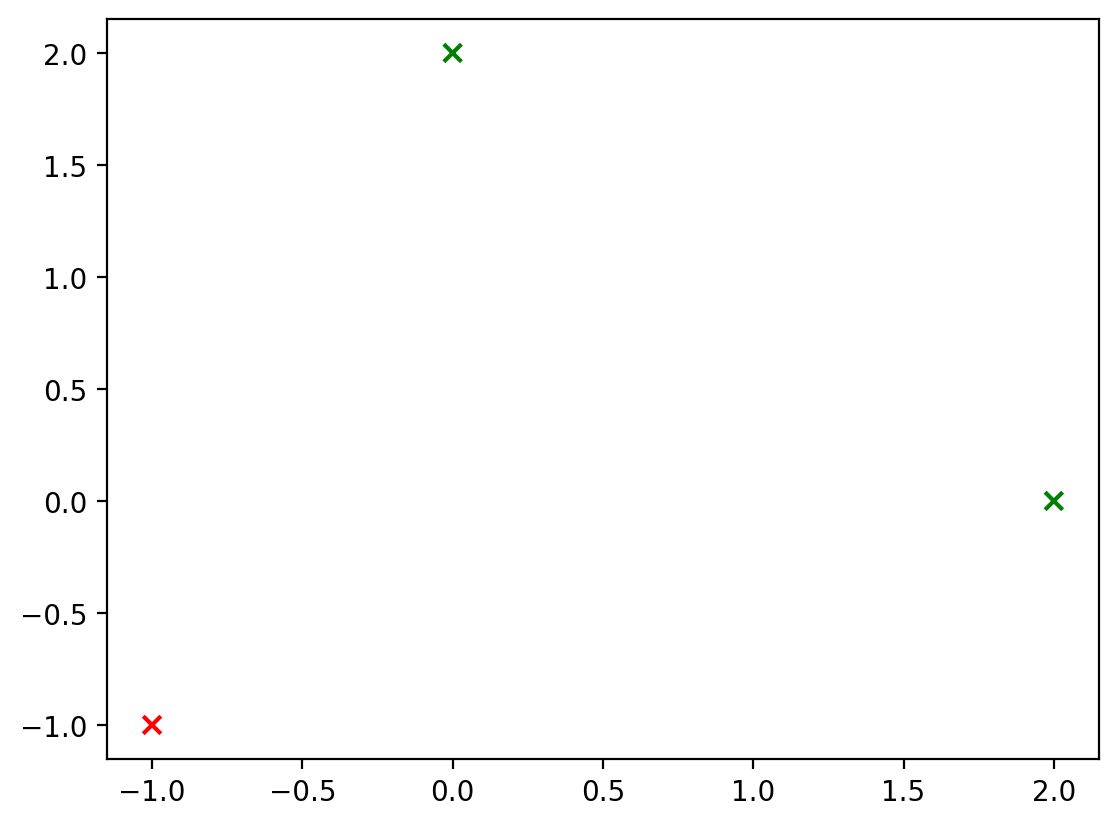

In [13]:
x = np.array([[0.0, 2.0], [2.0, 0.0], [-1.0, -1.0]])
t = np.array([1.0, 1.0, -1.0])

plt.scatter(x[:, 0], x[:, 1], s=40, c=[("g" if label == 1 else "r") for label in t], marker="x")
plt.show()

In [15]:
model = SupportVectorClassifier(kernel=None, C=np.inf)
model.fit(x, t)

print(f"Found {model.n_support_vectors} support vectors.")

Found 3 support vectors.


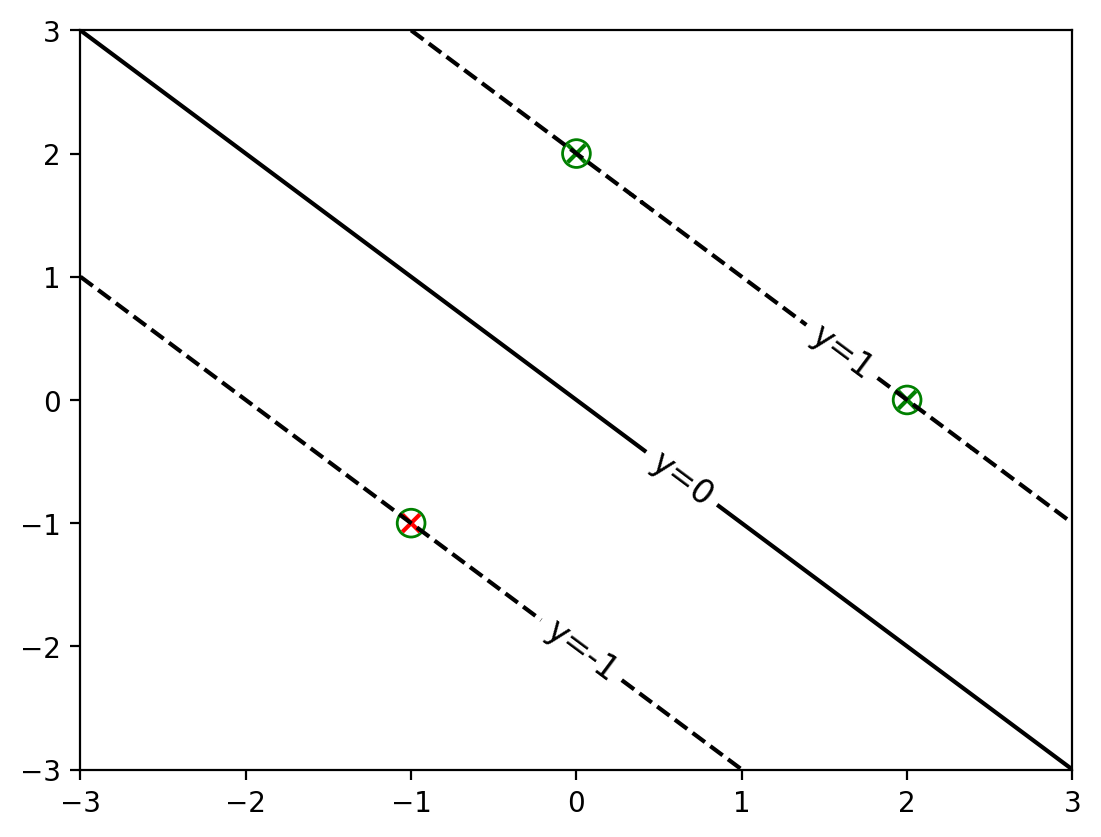

In [21]:
x0, x1 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
xx = np.array([x0, x1]).reshape(2, -1).T

plt.scatter(x[:, 0], x[:, 1], s=40, c=[("g" if label == 1 else "r") for label in t], marker="x")
plt.scatter(model.support_vectors[:, 0], model.support_vectors[:, 1], s=100, facecolor="none", edgecolor="g")
cp = plt.contour(
    x0,
    x1,
    model.predict(xx)[1].reshape(100, 100),
    np.array([-1, 0, 1]),
    colors="k",
    linestyles=("dashed", "solid", "dashed"),
)
plt.clabel(cp, fmt="y=%.f", inline=True, fontsize=12)
plt.show()

### 7.1.1 Overlapping class distributions

So far, we have assumed that the training data points are linearly separable in the feature space. Thus, support vector machine gives an exact separation in the original input space, although the corresponding decision boundary is non-linear. In practice, however, the class-conditional distributions may overlap, in which case exact separation of the training data can lead to poor generalization.

We therefore need to modify the support vector machine so as to allow some of the training points to be misclassified. In the case of separable classes, we implicitly used an error function that gave infinite error if a data point was misclassified and zero error if it was classified correctly, and then optimized the model parameters to maximize the margin. We may modify this approach so that data points are allowed to be on the *wrong side* of the margin boundary, but having a penalty that increases proportionally to their distance from that boundary. To that end, we introduce *slack variables*, $\xi_n \geq 0$ (one for each training data point), for which $\xi_n = 0$ when data points that are on or inside the correct margin boundary, and $\xi_n = |t_n − y(\mathbf{x}_n)|$ in any other case. Therefore, a data point that is on the decision boundary $y(\mathbf{x}_n) = 0$ has $\xi_n = 1$, and points having $\xi_n > 1$ are misclassified. The exact classification constraints are then replaced by,

$$
t_ny(\mathbf{x}_n) \geq 1 - \xi_n
$$

<img src="../images/fg7_3.png" width="400">

> This known as relaxing the hard-margin constraint to give a soft-margin. Note that while slack variables allow for overlapping class distributions, this framework is still sensitive to outliers because the penalty for misclassification increases linearly.

Our goal is thus to maximize the margin while softly penalizing points that lie on the wrong side of the margin boundary,

$$
\begin{aligned}
& \argmin_{\mathbf{w}, b}\frac{1}{2}||\mathbf{w}||_2^2 + C\sum_{n=1}^N \xi_n \\
& \text{subject to} \qquad t_n(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b) \geq 1 - \xi_n \\
& \qquad\qquad\qquad\; \xi_n \geq 0
\end{aligned}
$$

where the parameter $C > 0$ controls the trade-off between the slack variable penalty and the margin. Because any point that is misclassified has $\xi_n > 1$, it follows that $\sum_{n=1}^N \xi_n$ is an upper bound on the number of misclassified points. The parameter $C$ is analogous to (the inverse of) a regularization coefficient because it controls the trade-off between minimizing training errors and controlling model complexity. In the limit $C \rightarrow \infty$, recovers the earlier support vector machine for separable data.

In order to solve the optimization, the corresponding Lagrangian is given by

$$
L(\mathbf{w}, b, \mathbf{a}) = \frac{1}{2}||\mathbf{w}||_2^2 + C\sum_{n=1}^N \xi_n - \sum_{n=1}^N a_n \{t_ny(\mathbf{x}_n) - 1 + \xi_n\} - \sum_{n=1}^N\mu_n\xi_n
$$

and the derivatives for $\mathbf{w}$ and $b$ are identical to the hard-margin case, while the derivatives for $\xi_n$ is as follows,

$$
\begin{aligned}
\frac{\partial L}{\partial\xi_n} = 0 &\Leftrightarrow 
\frac{\partial}{\partial\xi_n} \Bigg( \frac{1}{2}||\mathbf{w}||_2^2 + C\sum_{n=1}^N \xi_n - \sum_{n=1}^N a_n \{t_ny(\mathbf{x}_n) - 1 + \xi_n\} - \sum_{n=1}^N\mu_n\xi_n \Bigg) = 0 \\
&\Leftrightarrow  C - \frac{\partial}{\partial\xi_n}\Bigg( \sum_{n=1}^N a_n \{t_ny(\mathbf{x}_n) - 1 + \xi_n\} \Bigg) - \mu_n = 0 \\
&\Leftrightarrow  C - a_n - \mu_n = 0 \\
&\Leftrightarrow  C - \mu_n = a_n
\end{aligned}
$$

Using these results to eliminate $\mathbf{w}$, $b$, $\xi_n$ from the Lagrangian, we obtain the dual representation, which is identical to the separable case, except that we have an additional constraint stating that $a_n \leq C$.

> Regarding the solution to the quadratic programming problem tha arise in both cases (separable and non-separable), a global optimum solution can be found since the constraints define a convex region (as a consequence of being linear). Direct solution of a quadratic programming problem may be demanding (in terms of computation and memory) using traditional techniques. One popular approach to training support vector machines is sequential minimal optimization (SMO). SMO considers two Lagrange multipliers at a time, and in this case, the subproblem can be solved analytically, thereby avoiding numerical quadratic programming altogether. Moreover, heuristics exist to choose the best pair of Lagrange multipliers to be considered at each step. In practice, SMO scales proportionally to the number of data points that is somewhere between linear and quadratic.


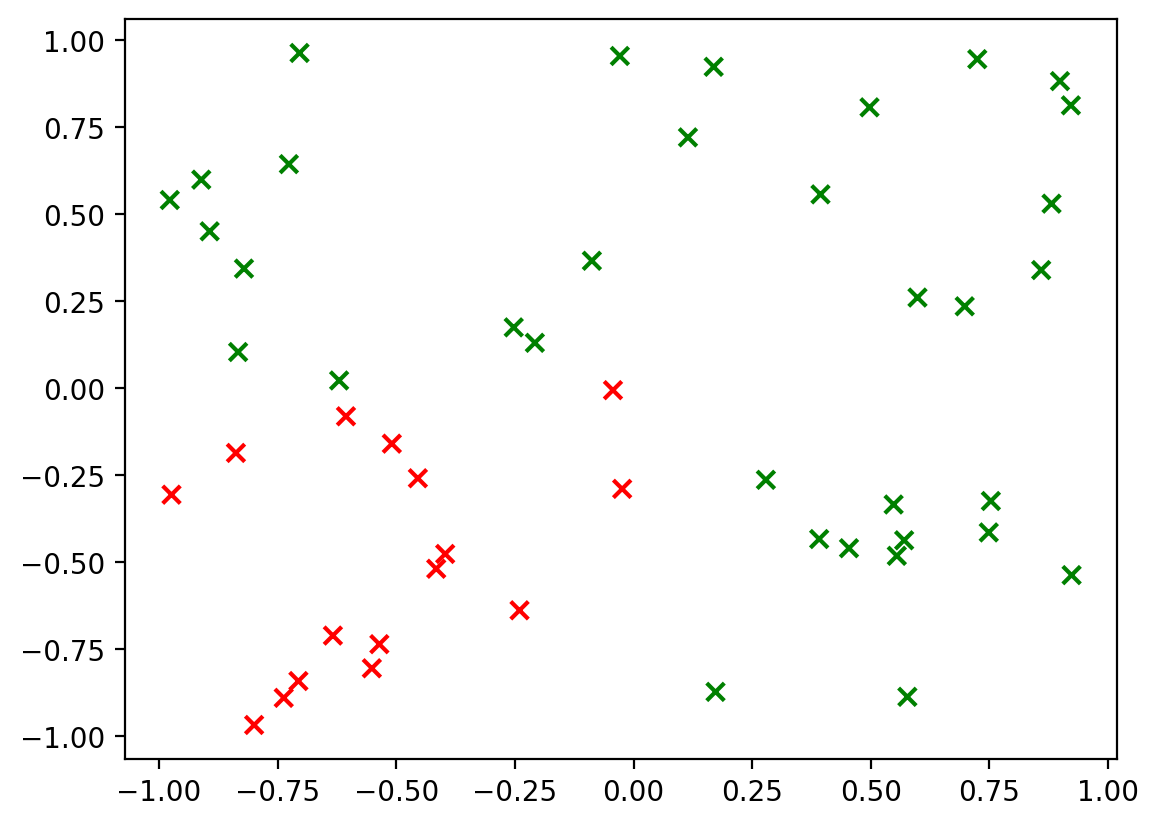

In [26]:
x = np.random.uniform(-1, 1, 100).reshape(-1, 2)
t = x < 0
t = (t[:, 0] * t[:, 1]).astype(float)
t = 1 - 2 * t

plt.scatter(x[:, 0], x[:, 1], s=40, c=[("g" if label == 1 else "r") for label in t], marker="x")
plt.show()

In [27]:
model = SupportVectorClassifier(RBF(theta=np.ones(2)))
model.fit(x, t)

print(f"Found {model.n_support_vectors} support vectors.")

Found 21 support vectors.


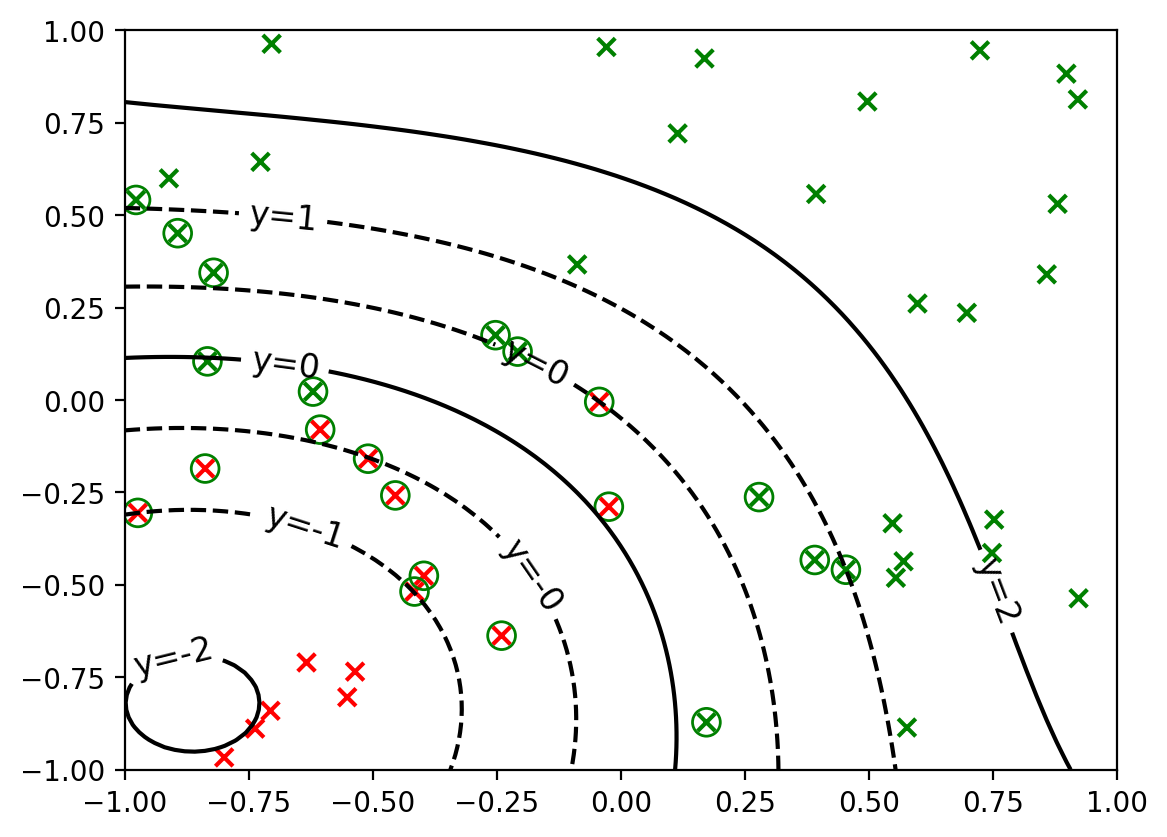

In [29]:
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
xx = np.array([x0, x1]).reshape(2, -1).T

plt.scatter(x[:, 0], x[:, 1], s=40, c=[("g" if label == 1 else "r") for label in t], marker="x")
plt.scatter(model.support_vectors[:, 0], model.support_vectors[:, 1], s=100, facecolor="none", edgecolor="g")
cp = plt.contour(x0, x1, model.predict(xx)[1].reshape(100, 100), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.clabel(cp, fmt="y=%.f", inline=True, fontsize=12)
plt.show()

### 7.1.2 Relation to logistic regresion

In order to study the relation of SVM to logistic regression, we can cast the SVM for non-separable distributions in terms of the minimization of a regularized error function. Data points that are on the correct side of the margin boundary, satisfy $y_nt_n \geq 1$ and $\xi_n = 0$, while for the remaining points we have $\xi_n = 1 − y_nt_n$. Thus, the objective function in the form,

$$
\sum_{n=1}^N E_{SV}(y_nt_n) + \lambda||\mathbf{w}||_2^2
$$

where $\lambda = (2C)−1$, and $E_{SV}(\cdot)$ is the *hinge error* function defined by,

$$
E_{SV}(y_nt_n) = [1 − y_nt_n]_+
$$

In the logistic regression model was convenient to work with target variable $t\in\{0,1\}$. Thus, for comparison with the support vector machine, we reformulate maximum likelihood logistic regression using the target variable $t\in\{-1,1\}$. To that end, note that $p(t=1|y)=\sigma(y)$. Therefore, $p(t=−1|y) = 1 − \sigma(y) = \sigma(−y)$, where we have used the properties
of the logistic sigmoid function. Therefore, combining the above cases, we obtain $p(t|y) = \sigma(yt)$.

Given this formulation, the negative logarithm of the likelihood function takes the form,

$$
\sum_{n=1}^N E_{LR}(y_nt_n) + \lambda||\mathbf{w}||_2^2
$$

For comparison with other error functions, we divide by $\ln(2)$ so that the error function passes through the point $(0, 1)$. Below we plot the reformulated error function for logistic regression along the hinge loss, the true misclassification error and the squared error.

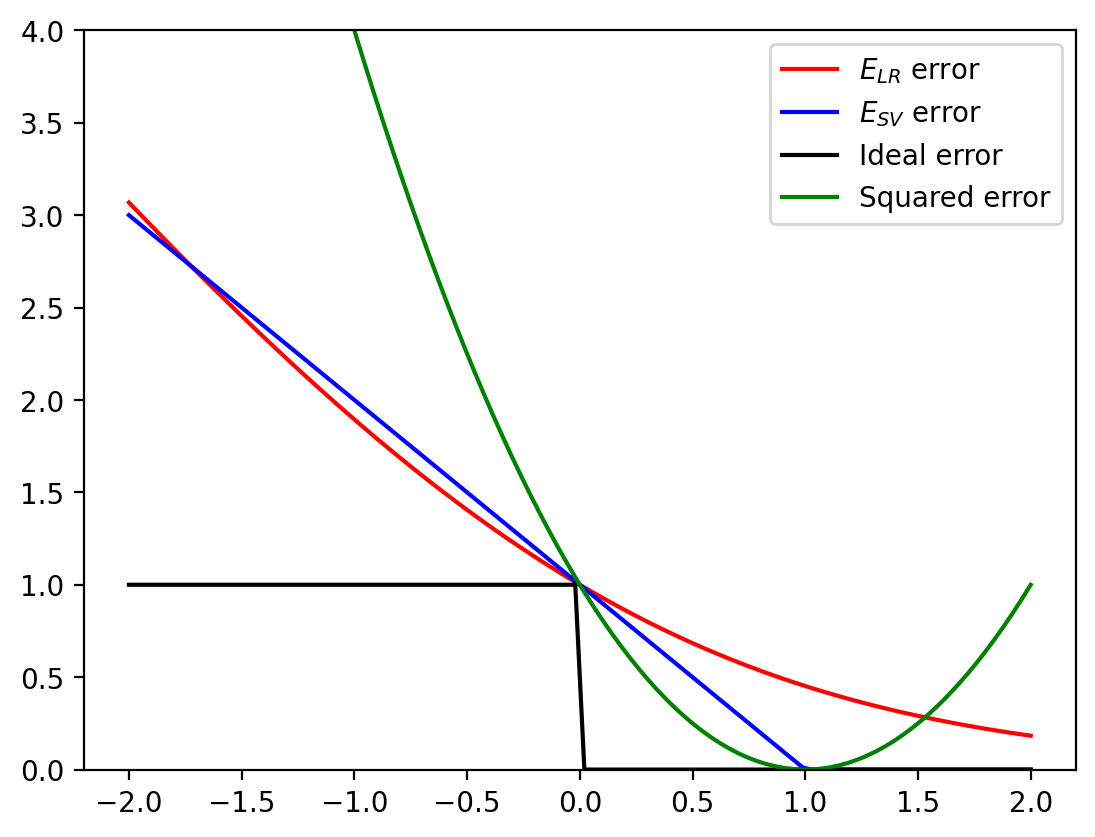

In [57]:
z = np.linspace(-2, 2, 100)

plt.plot(z, np.log(1 + np.exp(-z)) / np.log(2), label="$E_{LR}$ error", color="red")
plt.plot(z, np.where(1 - z > 0, 1 - z, 0), label="$E_{SV}$ error", color="blue")
plt.plot(z, np.where(z > 0, 0, 1), label="Ideal error", color="black")
plt.plot(z, (1 - z) ** 2, label="Squared error", color="green")
plt.ylim(0, 4)
plt.legend()
plt.show()

Note that the logistic regression error $E_{LR}$ has a similar form to the support vector error function. The main difference is that the flat region in $E_{SV}$ leads to sparse solutions. Both the logistic error and the hinge loss can be viewed as continuous approximations to the misclassification error. The squared error, on the other hand, places increasing emphasis on data points that are correctly classified. These points are strongly weighted at the expense of misclassified points, and so if the objective is to minimize the misclassification rate, then a monotonically decreasing error function is a better choice.

### 7.1.3 Multiclass SVM

The support vector machine is fundamentally a 2-class classifier. To tackle problems involving $K > 2$ classes, usually we combine multiple 2-class SVMs in order to build a multiclass classifier. One commonly used approach is to train $K$ separate SVMs, where the $k$th model $y_k(\mathbf{x})$ is trained using the data from class $C_k$ as the positive examples and the data from the remaining $K−1$ classes as the negative. This is known as the *one-versus-the-rest* approach. In order to avoid inconsistent results, that is, assigning input examples to multiple classes simultaneously, the predictions are made as follows,

$$
y(\mathbf{x}) = \max_k y_k(\mathbf{x})
$$

**Issues:**

1. Since different each classifier is trained independantly, there is no guarantee that the real-valued quantities $y_k(\mathbf{x})$ for different classifiers will have appropriate scales.
2. Training sets are imbalanced. For ten classes each having equal numbers of training data points, then the individual classifiers are trained on data sets comprising $90\%$ negative and $10\%$ positive examples.

Another approach is to train $K(K − 1)/2$ different 2-class SVM on all possible pairs of classes, and then to classify test points according to which class has the highest number of *votes*, an approach that is sometimes called *one-versus-one*. Note that for large $K$ this approach requires significantly more computation than the *one-versus-the-rest* approach.

### 7.1.4 SVMs for regression

In order to extend support vector machines to regression problems and obtain sparse solutions, the quadratic error function is replaced by an $\epsilon$-insensitive error function, which gives zero error if the absolute difference between the prediction $y(\mathbf{x})$ and the target $t$ is less than $\epsilon$ where $\epsilon > 0$. A simple example of an $\epsilon$-insensitive error function, having a linear cost associated with errors outside the insensitive region, is given by

$$
E_{\epsilon}(y(\mathbf{x}) - t) = 
\begin{cases}
0 & \text{if} \; |y(\mathbf{x}) - t| < \epsilon\\
|y(\mathbf{x}) - t| - \epsilon & \text{otherwise}
\end{cases}
$$

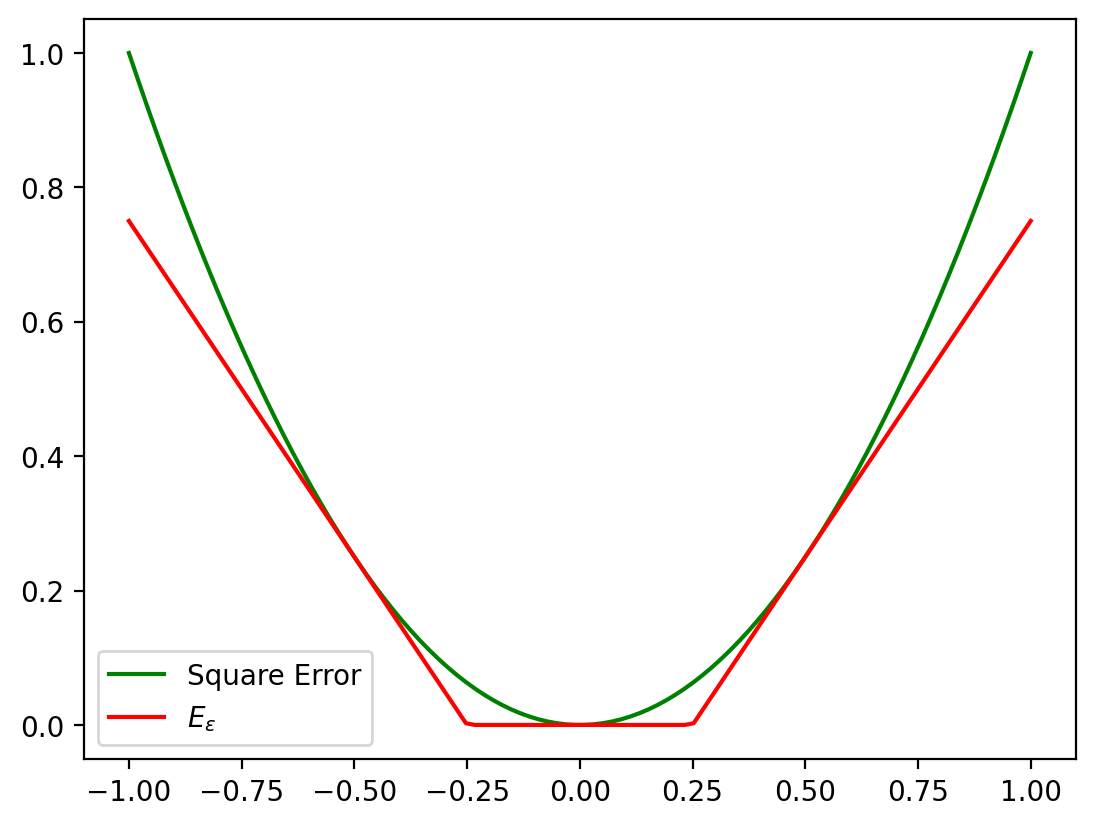

In [74]:
epsilon = 0.25

z = np.linspace(-1, 1, 100)

plt.plot(z, z**2, color="green", label="Square Error")
plt.plot(z, np.where(np.abs(z) < epsilon, 0, np.abs(z) - epsilon), color="red", label="$E_\epsilon$")
plt.legend()
plt.show()

Thus, we can minimize a regularized error function given by,

$$
C \sum_{n=1}^N E_{\epsilon}(y(\mathbf{x}) - t) + \frac{1}{2} ||\mathbf{w}||_2^2
$$

where $C$ is the (inverse) regularization parameter. For each data point $\mathbf{x}_n$, we introduce two slack variables $\xi_n, \hat{\xi}_n \geq 0$, where $\xi_n > 0$ corresponds to a point for which $t_n > y(\mathbf{x}_n) + \epsilon$, and $\hat{\xi}_n > 0$ corresponds to a point for which $t_n < y(\mathbf{x}_n) - \epsilon$. These slack variables allows points to lie outside the $\epsilon$-tube provided the slack variables are nonzero, and the corresponding conditions are

$$
\begin{aligned}
t_n \leq y(\mathbf{x}_n) + \epsilon + \xi_n \\
t_n \geq y(\mathbf{x}_n) - \epsilon - \xi_n
\end{aligned}
$$

Thus, the error function for support vector regression can then be written as

$$
C \sum_{n=1}^N (\xi_n + \hat{\xi}_n) + \frac{1}{2} ||\mathbf{w}||_2^2
$$

where $\xi_n + \hat{\xi}_n$ measures the amount by which data point $\mathbf{x}_n$ lies outside the $\epsilon$-tube.

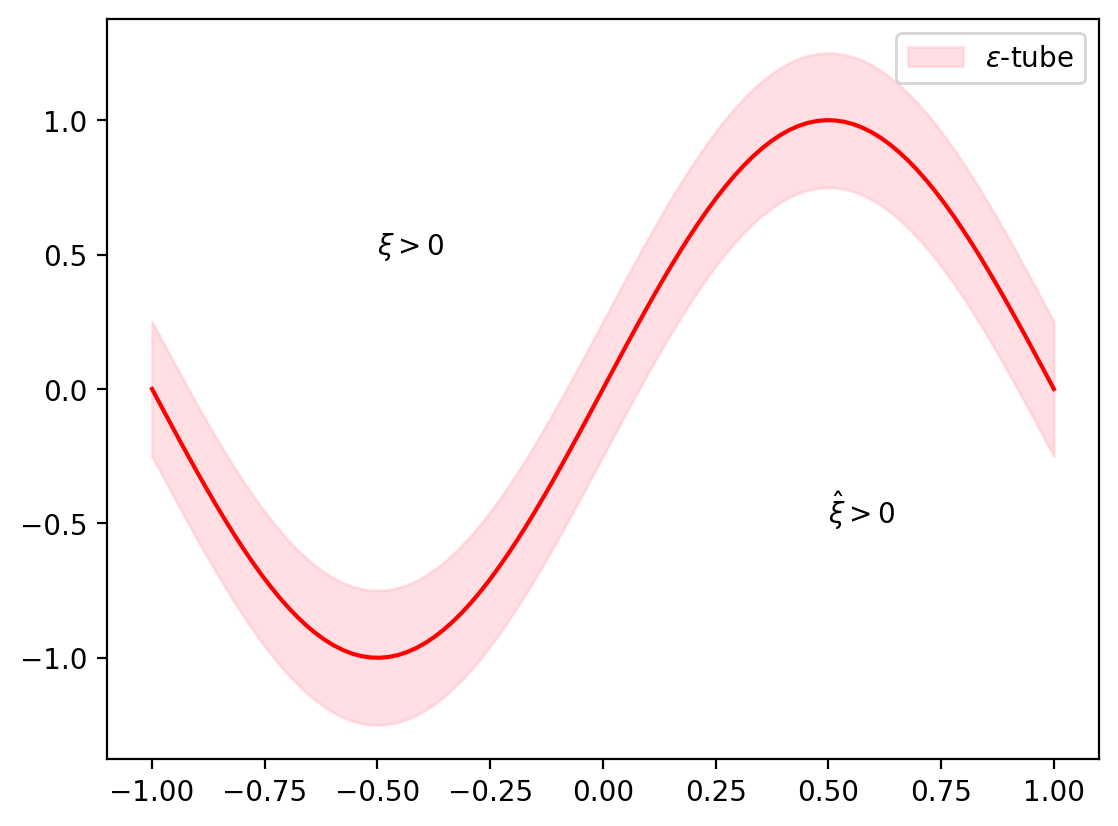

In [90]:
epsilon = 0.25
x = np.linspace(-1, 1, 100)
y = np.sin(np.pi * x)

plt.plot(x, y, color="red")
plt.fill_between(
    x,
    y - epsilon,
    y + epsilon,
    alpha=0.5,
    color="pink",
    label="$\epsilon$-tube",
)
plt.text(-0.5, 0.5, "$\\xi > 0$")
plt.text(0.5, -0.5, "$\\hat{\\xi} > 0$")
plt.legend()
plt.show()

The error function can be minimized by introducing Lagrange multipliers $a_n, \hat{a}_n, \mu_n, \hat{\mu}_n$ to obtain,

$$
L(\mathbf{w}, b, \mathbf{a}, \hat{\mathbf{a}}) = C\sum_{n=1}^N (\xi_n + \hat{\xi}_n) + \frac{1}{2}||\mathbf{w}||_2^2 
- \sum_{n=1}^N (\mu_n\xi_n + \hat{\mu}_n\hat{\xi}_n) 
- \sum_{n=1}^N a_n (\epsilon + \xi_n + y_n - t_n)
- \sum_{n=1}^N \hat{a}_n (\epsilon + \hat{\xi}_n - y_n + t_n)
$$

By setting the derivatives of the Lagrangian with respect to $\mathbf{w}$, $b$, $\xi_n$, and $\hat{\xi}_n$ to zero, we obtain,

$$
\begin{aligned}
    dL_{\mathbf{w}} = 0 &\Leftrightarrow \mathbf{w} 
    - \frac{d}{d\mathbf{w}} \Bigg( \sum_{n=1}^N a_n (\epsilon + \xi_n + y_n - t_n) + \sum_{n=1}^N \hat{a}_n (\epsilon + \hat{\xi}_n - y_n + t_n) \Bigg) = 0 \\
    &\Leftrightarrow \mathbf{w} 
    - \frac{d}{d\mathbf{w}} \Bigg( 
        \sum_{n=1}^N a_n (\epsilon + \xi_n + \mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b - t_n) 
        + \sum_{n=1}^N \hat{a}_n (\epsilon + \hat{\xi}_n - \mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - b + t_n) 
    \Bigg) = 0 \\
    &\Leftrightarrow \mathbf{w} - \sum_{n=1}^N a_n\boldsymbol\phi(\mathbf{x}_n) + \sum_{n=1}^N \hat{a}_n\boldsymbol\phi(\mathbf{x}_n) = 0 \\
    &\Leftrightarrow \mathbf{w} = \sum_{n=1}^N (a_n - \hat{a}_n) \boldsymbol\phi(\mathbf{x}_n)
\end{aligned}
$$

$$
\begin{aligned}
    dL_b = 0 &\Leftrightarrow - \frac{d}{db} \Bigg( \sum_{n=1}^N a_n (\epsilon + \xi_n + y_n - t_n) + \sum_{n=1}^N \hat{a}_n (\epsilon + \hat{\xi}_n - y_n + t_n) \Bigg) = 0 \\
    &\Leftrightarrow - \frac{d}{db} \Bigg( 
        \sum_{n=1}^N a_n (\epsilon + \xi_n + \mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b - t_n) 
        + \sum_{n=1}^N \hat{a}_n (\epsilon + \hat{\xi}_n - \mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) - b + t_n) 
    \Bigg) = 0 \\
    &\Leftrightarrow - \sum_{n=1}^N a_n + \sum_{n=1}^N \hat{a}_n = 0 \\
    &\Leftrightarrow \sum_{n=1}^N (a_n - \hat{a}_n) = 0
\end{aligned}
$$

while the derivatives for $\xi_n$, and $\hat{\xi}_n$ are identical to $(7.31)$. Using these results to eliminate the corresponding variables from the Lagrangian, the dual representation is as follows,

$$
\begin{aligned}
\tilde{L}(\mathbf{a}, \hat{\mathbf{a}}) &= 
C\sum_{n=1}^N (\xi_n + \hat{\xi}_n) + \frac{1}{2}||\mathbf{w}||_2^2 
- \sum_{n=1}^N (\mu_n\xi_n + \hat{\mu}_n\hat{\xi}_n) 
- \sum_{n=1}^N a_n (\epsilon + \xi_n + y_n - t_n)
- \sum_{n=1}^N \hat{a}_n (\epsilon + \hat{\xi}_n - y_n + t_n) \\

&= \frac{1}{2}||\mathbf{w}||_2^2
+ \sum_{n=1}^N (C - \mu_n)\xi_n + (C - \hat{\mu}_n)\hat{\xi}_n 
- \sum_{n=1}^N a_n (\epsilon + \xi_n + y_n - t_n)
- \sum_{n=1}^N \hat{a}_n (\epsilon + \hat{\xi}_n - y_n + t_n) \\

&= \frac{1}{2}||\mathbf{w}||_2^2
+ \sum_{n=1}^N a_n\xi_n + \sum_{n=1}^N \hat{a}_n\hat{\xi}_n 
- \sum_{n=1}^N a_n (\epsilon + \xi_n + y_n - t_n)
- \sum_{n=1}^N \hat{a}_n (\epsilon + \hat{\xi}_n - y_n + t_n) \\

&= \frac{1}{2}||\mathbf{w}||_2^2
- \sum_{n=1}^N a_n (\epsilon + y_n - t_n)
- \sum_{n=1}^N \hat{a}_n (\epsilon - y_n + t_n) \\

&= \frac{1}{2}||\mathbf{w}||_2^2
- \epsilon\sum_{n=1}^N (a_n + \hat{a}_n)
- \sum_{n=1}^N (a_n - \hat{a}_n)y_n
+ \sum_{n=1}^N (a_n - \hat{a}_n)t_n \\

&= \frac{1}{2}||\mathbf{w}||_2^2
- \epsilon\sum_{n=1}^N (a_n + \hat{a}_n)
- \sum_{n=1}^N (a_n - \hat{a}_n)(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b)
+ \sum_{n=1}^N (a_n - \hat{a}_n)t_n \\

&= \frac{1}{2}||\mathbf{w}||_2^2
- \epsilon\sum_{n=1}^N (a_n + \hat{a}_n)
- \sum_{n=1}^N (a_n - \hat{a}_n)( \sum_{m=1}^N (a_m - \hat{a}_m)\boldsymbol\phi(\mathbf{x}_m)^T\boldsymbol\phi(\mathbf{x}_n) + b)
+ \sum_{n=1}^N (a_n - \hat{a}_n)t_n \\

&= \frac{1}{2}||\mathbf{w}||_2^2
- \epsilon\sum_{n=1}^N (a_n + \hat{a}_n)
- \sum_{n=1}^N \sum_{m=1}^N (a_n - \hat{a}_n)(a_m - \hat{a}_m)\boldsymbol\phi(\mathbf{x}_m)^T\boldsymbol\phi(\mathbf{x}_n)
- b\sum_{n=1}^N (a_n - \hat{a}_n)
+ \sum_{n=1}^N (a_n - \hat{a}_n)t_n \\

&= \frac{1}{2}||\mathbf{w}||_2^2
- \sum_{n=1}^N \sum_{m=1}^N (a_n - \hat{a}_n)(a_m - \hat{a}_m)\boldsymbol\phi(\mathbf{x}_m)^T\boldsymbol\phi(\mathbf{x}_n)
- \epsilon\sum_{n=1}^N (a_n + \hat{a}_n)
+ \sum_{n=1}^N (a_n - \hat{a}_n)t_n \\

&= -\frac{1}{2}\sum_{n=1}^N \sum_{m=1}^N (a_n - \hat{a}_n)(a_m - \hat{a}_m)k(\mathbf{x}_m,\mathbf{x}_n)
- \epsilon\sum_{n=1}^N (a_n + \hat{a}_n)
+ \sum_{n=1}^N (a_n - \hat{a}_n)t_n \\
\end{aligned}
$$

which we optimize together with the following box contraints,

$$
0 \leq a_n \leq C \\
0 \leq \hat{a}_n \leq C \\
$$

Substituting $(7.57)$ into $(7.1)$, the predictions for new inputs are made using,

$$
y = \sum_{n=1}^N (a_n - \hat{a}_n)k(\mathbf{x}_n, \mathbf{x}) + b
$$

The support vectors are those data points that contribute to predictions given by $(a_n - \hat{a}_n)$, or in other words those for which either $a_n = 0$ or $\hat{a}_n = 0$. These are points that lie on the boundary of the $\epsilon$-tube or outside the tube. All points within the tube have $a_n = \hat{a}_n = 0$. The parameter $b$ can be found either by considering a data point for which $0 < a_n < C$ or $0 < \hat{a}_n < C$. For such a point holds $\xi_n = 0$, and thus, from $(7.65)$ must therefore satisfy $\epsilon + y_n − t_n = 0$,

$$
\epsilon + y_n − t_n = 0 \Leftrightarrow y_n = t_n - \epsilon \Leftrightarrow \mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n) + b = t_n - \epsilon 
\Leftrightarrow b = t_n - \epsilon - \mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n)
$$

In practice, its better to average over all such estimates of $b$.

In [ ]:
x_space = np.linspace(-1, 1, 100)
t_space = np.sin(np.pi * x_space)

x, t = generate_toy_data(lambda x: np.sin(np.pi * x), 20, 0.25, domain=(-1, 1))

epsilon = 0.3
model = SupportVectorRegressor(kernel=RBF(theta=np.array(10)), epsilon=epsilon)
model.fit(x, t)
print(f"Found {model.n_support_vectors} support vectors.")

plt.scatter(x, t)
plt.plot(x_space, t_space, color="green", label="$\sin(2\pi x)$")
plt.fill_between(
    x_space,
    t_space - epsilon,
    t_space + epsilon,
    alpha=0.5,
    color="pink",
    label="$\epsilon$-tube",
)

f = (model._lambda * model._support_labels) @ model.kernel(model._support_vectors, x_space[:, None]) + model.b
plt.plot(x_space, f, color="red", label="SVM")
plt.legend()
plt.show()

## 7.2 Relevance Vector Machines

SVMs suffer from a number of limitations. In particular, the outputs of an SVM represent decisions rather than posterior probabilities. Also, the SVM is formulated for two classes, and the extension to $K > 2$ classes is problematic. Finally, the complexity parameter $C$, or $\nu$ (and $\epsilon$ in the case of regression), must be found using a hold-out methods. The *relevance vector machine* (RVM) is a Bayesian sparse kernel technique for regression and classification that is similar to SVM whilst avoiding its principal limitations. Additionally, it leads to much sparser models that yield faster performance on test data, while maintaining comparable generalization error.

### 7.2.1 RVM for regression

The relevance vector machine for regression is a linear model, similar to the one presented in [Chapter 3](ch3_linear_models_for_regression). The key difference is that we introduce a separate prior hyperparameter $\alpha_i$ for each of the weight parameter $w_i$ instead of a single shared hyperparameter, 

$$
p(\mathbf{w}|\boldsymbol\alpha) = \prod_{i=1}^M \mathcal{N}(w_i|0, \alpha_i^{-1})
$$

We shall see that, maximizing the evidence with respect to these hyperparameters, a significant proportion of them go to infinity, and the corresponding weight parameters have posterior distributions that are concentrated at zero, thus resuling in sparse solutions, since the associated basis functions play no role in the predictions and so are effectively pruned out.

Using the result $(3.49)$ for linear regression models, the posterior distribution for the weights is Gaussian and takes the form,

$$
p(\mathbf{w}|\mathbf{X}, \mathsf{t}, \boldsymbol\alpha, \beta) = \mathcal{N}(\mathbf{w}|\mathbf{m},\mathbf{\Sigma})
$$

where the mean and covariance are given by

$$
\begin{aligned}
&\mathbf{m} = \beta\mathbf{\Sigma}\boldsymbol\Phi^T\mathsf{t} \\
&\mathbf{\Sigma} = (\mathbf{A} + \beta\boldsymbol\Phi^T\boldsymbol\Phi)^{-1}
\end{aligned}
$$

where $\mathbf{A} = diag(\alpha_i)$. Note that if $\boldsymbol\Phi = \mathbf{K}$, then $\mathbf{K}$ is the symmetric $(N + 1) \times (N + 1)$ kernel matrix.

The values of $\boldsymbol\alpha$ and $\beta$ are determined using type-$2$ maximum likelihood, also known as the *evidence approximation*, in which we maximize the marginal likelihood obtained by integrating out the weight parameters,

$$
\begin{aligned}
p(\mathsf{t}|\mathbf{X}, \boldsymbol\alpha, \beta) &= \int p(\mathsf{t}|\mathbf{w}, \mathbf{X}, \boldsymbol\alpha, \beta) p(\mathbf{w}|\boldsymbol\alpha) d\mathbf{w} \\
&= \int \mathcal{N}(\mathsf{t}|\mathbf{w}^T\boldsymbol\Phi, \beta^{-1}\mathbf{I}) \mathcal{N}(\mathbf{w}|\mathbf{0}, \boldsymbol\alpha\mathbf{I}) d\mathbf{w} \\
&= \Big(\frac{\beta}{2\pi}\Big)^{N/2} 
\int \exp\Big\{ -\frac{\beta}{2}||\mathsf{t} - \boldsymbol\Phi^T\mathbf{w}||_2^2 \Big\} \mathcal{N}(\mathbf{w}|\mathbf{0}, \boldsymbol\alpha^{-1}\mathbf{I}) d\mathbf{w} \\
&= \Big(\frac{\beta}{2\pi}\Big)^{N/2} \frac{1}{(2\pi)^{M/2}|\mathbf{A}|^{1/2}}
\int \exp\Big\{ -\frac{\beta}{2}||\mathsf{t} - \boldsymbol\Phi^T\mathbf{w}||_2^2 \Big\} \exp\Big\{ -\frac{1}{2}\mathbf{w}^T\mathbf{A}\mathbf{w} \Big\} d\mathbf{w} \\
&\overset{\mathbf{A}\text{ is diagonal}}{=} \Big(\frac{\beta}{2\pi}\Big)^{N/2} \frac{1}{(2\pi)^{M/2}}\prod_{m=1}^M a_m^{1/2}
\int \exp\Big\{ -\frac{\beta}{2}||\mathsf{t} - \boldsymbol\Phi^T\mathbf{w}||_2^2 \Big\} \exp\Big\{ -\frac{1}{2}\mathbf{w}^T\mathbf{A}\mathbf{w} \Big\} d\mathbf{w} \\
&\overset{e^ae^b=e^{a+b}}{=} \Big(\frac{\beta}{2\pi}\Big)^{N/2} \frac{1}{(2\pi)^{M/2}}\prod_{m=1}^M a_m^{1/2}
\int \exp\Big\{ -\frac{1}{2} \Big( \beta||\mathsf{t} - \boldsymbol\Phi^T\mathbf{w}||_2^2 + \mathbf{w}^T\mathbf{A}\mathbf{w} \Big) \Big\} d\mathbf{w} \\
&= \Big(\frac{\beta}{2\pi}\Big)^{N/2} \frac{1}{(2\pi)^{M/2}}\prod_{m=1}^M a_m^{1/2}
\int \exp\Big\{ -\frac{1}{2}E(\mathbf{w}) \Big\} d\mathbf{w}
\end{aligned}
$$

where

$$
\begin{aligned}
E(\mathbf{w}) &= \beta||\mathsf{t} - \boldsymbol\Phi^T\mathbf{w}||_2^2 + \mathbf{w}^T\mathbf{A}\mathbf{w} \\
&= \beta\mathsf{t}^T\mathsf{t} - 2\beta\mathsf{t}^T\boldsymbol\Phi^T\mathbf{w} + \beta\mathbf{w}^T\boldsymbol\Phi^T\boldsymbol\Phi\mathbf{w} + \mathbf{w}^T\mathbf{A}\mathbf{w} \\
&= \beta\mathsf{t}^T\mathsf{t} - 2\beta\mathsf{t}^T\boldsymbol\Phi^T\mathbf{w} + \mathbf{w}^T(\mathbf{A} + \beta\boldsymbol\Phi^T\boldsymbol\Phi)\mathbf{w} \\
&= \beta\mathsf{t}^T\mathsf{t} - 2\beta\mathsf{t}^T\boldsymbol\Phi^T\mathbf{w} + \mathbf{w}^T\mathbf{\Sigma}^{-1}\mathbf{w} \\
&\overset{\beta\mathsf{t}^T\boldsymbol\Phi^T=\mathbf{m}^T\mathbf{\Sigma}^{-1}}{=} 
\beta\mathsf{t}^T\mathsf{t} - 2\mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{w} + \mathbf{w}^T\mathbf{\Sigma}^{-1}\mathbf{w} \\
&= \beta\mathsf{t}^T\mathsf{t} - \mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{w} - \mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{w} + \mathbf{w}^T\mathbf{\Sigma}^{-1}\mathbf{w} \\
&= \beta\mathsf{t}^T\mathsf{t} - \mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{w} + (\mathbf{w} - \mathbf{m})^T\mathbf{\Sigma}^{-1}\mathbf{w} \\
&= \beta\mathsf{t}^T\mathsf{t} + (\mathbf{w} - \mathbf{m})^T\mathbf{\Sigma}^{-1}(\mathbf{w} - \mathbf{m}) - \mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{m}
\end{aligned}
$$

Therefore, substituting $E(\mathbf{w})$ back into the integral we obtain,

$$
\begin{aligned}
p(\mathsf{t}|\mathbf{X}, \boldsymbol\alpha, \beta) &= 
\Big(\frac{\beta}{2\pi}\Big)^{N/2} \frac{1}{(2\pi)^{M/2}}\prod_{m=1}^M a_m^{1/2} \int \exp\Big\{ -\frac{1}{2}E(\mathbf{w}) \Big\} d\mathbf{w} \\
&= \Big(\frac{\beta}{2\pi}\Big)^{N/2} \frac{1}{(2\pi)^{M/2}}\prod_{m=1}^M a_m^{1/2} \int 
\exp\Big\{-\frac{1}{2} \Big(
    \beta\mathsf{t}^T\mathsf{t} + (\mathbf{w} - \mathbf{m})^T\mathbf{\Sigma}^{-1}(\mathbf{w} - \mathbf{m}) - \mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{m}
\Big) \Big\} d\mathbf{w} \\
&= \Big(\frac{\beta}{2\pi}\Big)^{N/2} \frac{1}{(2\pi)^{M/2}}\prod_{m=1}^M a_m^{1/2} 
\exp\Big\{ \frac{1}{2}\mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{m} - \frac{\beta}{2}\mathsf{t}^T\mathsf{t} \Big\}
\int  \exp\Big\{-\frac{1}{2} (\mathbf{w} - \mathbf{m})^T\mathbf{\Sigma}^{-1}(\mathbf{w} - \mathbf{m}) \Big\} d\mathbf{w} \\
&= \Big(\frac{\beta}{2\pi}\Big)^{N/2} \frac{1}{(2\pi)^{M/2}}\prod_{m=1}^M a_m^{1/2} (2\pi)^{M/2} |\mathbf{\Sigma}|^{1/2}
\exp\Big\{ \frac{1}{2}\mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{m} - \frac{\beta}{2}\mathsf{t}^T\mathsf{t} \Big\} \\
&= \Big(\frac{\beta}{2\pi}\Big)^{N/2} \prod_{m=1}^M a_m^{1/2} |\mathbf{\Sigma}|^{1/2}
\exp\Big\{ \frac{1}{2}\mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{m} - \frac{\beta}{2}\mathsf{t}^T\mathsf{t} \Big\} \\
&= \Big(\frac{\beta}{2\pi}\Big)^{N/2} \prod_{m=1}^M a_m^{1/2} |\mathbf{\Sigma}|^{1/2} \exp\Big\{ -\frac{1}{2}E(\mathsf{t}) \Big\}
\end{aligned}
$$

where

$$
\begin{aligned}
E(\mathsf{t}) &= \beta\mathsf{t}^T\mathsf{t} - \mathbf{m}^T\mathbf{\Sigma}^{-1}\mathbf{m} \\
&= \beta\mathsf{t}^T\mathsf{t}  - \beta^2\mathsf{t}^T\boldsymbol\Phi\mathbf{\Sigma}\mathbf{\Sigma}^{-1}\mathbf{\Sigma}\boldsymbol\Phi^T\mathsf{t} \\
&= \beta\mathsf{t}^T\mathsf{t}  - \beta^2\mathsf{t}^T\boldsymbol\Phi\mathbf{\Sigma}\boldsymbol\Phi^T\mathsf{t} \\
&= \mathsf{t}^T(\beta\mathbf{I}  - \beta^2\boldsymbol\Phi\mathbf{\Sigma}\boldsymbol\Phi^T)\mathsf{t} \\
&= \mathsf{t}^T(\beta\mathbf{I}  - \beta\boldsymbol\Phi(\mathbf{A} + \beta\boldsymbol\Phi^T\boldsymbol\Phi)^{-1}\boldsymbol\Phi^T\beta)\mathsf{t} \\
&\overset{(C.7) \textit{Woodbury identity}}{=} 
\mathsf{t}^T (\beta^{-1}\mathbf{I} + \boldsymbol\Phi\mathbf{A}^{-1}\boldsymbol\Phi^T)^{-1} \mathsf{t}
\end{aligned}
$$

and for the *Woodbury identity* $(C.7)$ we have used the following mapping,

$$
\begin{aligned}
\mathbf{A} &= \beta\mathbf{I} \\
\mathbf{B} &= \boldsymbol\Phi \\
\mathbf{C} &= \boldsymbol\Phi^T \\
\mathbf{D} &= \mathbf{A}
\end{aligned}
$$

Therefore, 

$$
\begin{aligned}
p(\mathsf{t}|\mathbf{X}, \boldsymbol\alpha, \beta) = \Big(\frac{\beta}{2\pi}\Big)^{N/2} \prod_{m=1}^M a_m^{1/2} |\mathbf{\Sigma}|^{1/2} 
\exp\Big\{ -\frac{1}{2} \mathsf{t}^T (\beta^{-1}\mathbf{I} + \boldsymbol\Phi\mathbf{A}^{-1}\boldsymbol\Phi^T)^{-1} \mathsf{t} \Big\} 
= \Big(\frac{\beta}{2\pi}\Big)^{N/2} \prod_{m=1}^M a_m^{1/2} |\mathbf{\Sigma}|^{1/2} 
\exp\Big\{ -\frac{1}{2} \mathsf{t}^T \mathbf{C}^{-1} \mathsf{t} \Big\}
= \mathcal{N}(\mathsf{t}|\mathbf{0},\mathbf{C})
\end{aligned}
$$

where we have defined the $N \times N$ matrix $\mathbf{C}$ given by

$$
\mathbf{C} = \beta^{-1}\mathbf{I} + \boldsymbol\Phi\mathbf{A}^{-1}\boldsymbol\Phi^T
$$

Since this represents the convolution of two Gaussians, it can be evaluated to give the log marginal likelihood in the form,

$$
\ln p(\mathsf{t}|\mathbf{X}, \boldsymbol\alpha, \beta) = \ln\mathcal{N}(\mathsf{t}|\mathbf{0}, \mathbf{C}) = 
-\frac{1}{2} \{ N\ln(2\pi) + \ln|\mathbf{C}| + \mathsf{t}^T\mathbf{C}^{-1}\mathsf{t}\}
$$

In order to maximize the resulting marginal likelihood with respect to the hyperparameters $\boldsymbol\alpha$ and $\beta$, simply set the derivatives of the marginal likelihood to zero and obtain the following re-estimation equations,

$$
\begin{aligned}
\alpha_i^{new} &= \frac{1 - \alpha_i\Sigma_{ii}}{m_i^2} \\
(\beta^{new})^{-1} &= \frac{||\mathsf{t} - \boldsymbol\Phi\mathbf{m}||_2^2}{N - \sum_i (1 - \alpha_i\Sigma_{ii})}
\end{aligned}
$$

Learning therefore proceeds by choosing initial values for $\boldsymbol\alpha$ and $\beta$, evaluating the mean and covariance of the posterior, and then alternately re-estimating the hyperparameters, and re-estimating the posterior mean and covariance, until a suitable convergence criterion is satisfied.

> As a result of the optimization, a proportion of the hyperparameters $\alpha_i$ are driven to large (in principle infinite) values, and so the corresponding weight parameters $w_i$ have posterior distributions with mean and variance both zero. Thus those parameters, and the corresponding basis functions, are removed from the model and play no role in making predictions. In  the case of the dual representation, the inputs $\mathbf{x}_n$ corresponding to the remaining non-zero weights are called relevance vectors, because they are identified through the mechanism of automatic relevance determination, and are analogous to the support vectors of an SVM.

Having found values $\boldsymbol\alpha^{\star}$ and $\beta^{\star}$ for the hyperparameters that maximize the marginal likelihood, we can evaluate the predictive distribution over $t$ for a new input $\mathbf{x}^{new}$,

$$
p(t|\mathbf{x}^{new}, \mathbf{X}, \mathsf{t}, \boldsymbol\alpha^{\star}, \beta^{\star}) = 
\int p(t|\mathbf{x}^{new}, \mathbf{w}, \beta^{\star}) p(\mathbf{w}|\mathbf{X}, \mathsf{t}, \boldsymbol\alpha^{\star}, \beta^{\star}) d\mathbf{w} =
\mathcal{N}(t|\mathbf{m}^T\boldsymbol\phi(\mathbf{x}), \sigma(\mathbf{x})^2)
$$

Similar to [Chapter 3](ch3_linear_models_for_regression.ipynb), the result of the integral is a Gaussian distribution and the variance of the predictive distribution is given by,

$$
\sigma(\mathbf{x})^2 = \frac{1}{\beta^{\star}} + \boldsymbol\phi(\mathbf{x})^T\mathbf{\Sigma}\boldsymbol\phi(\mathbf{x})
$$

The following example presents an RVM applied to the sinusoidal regression data set:

Found 4 relevance vectors.


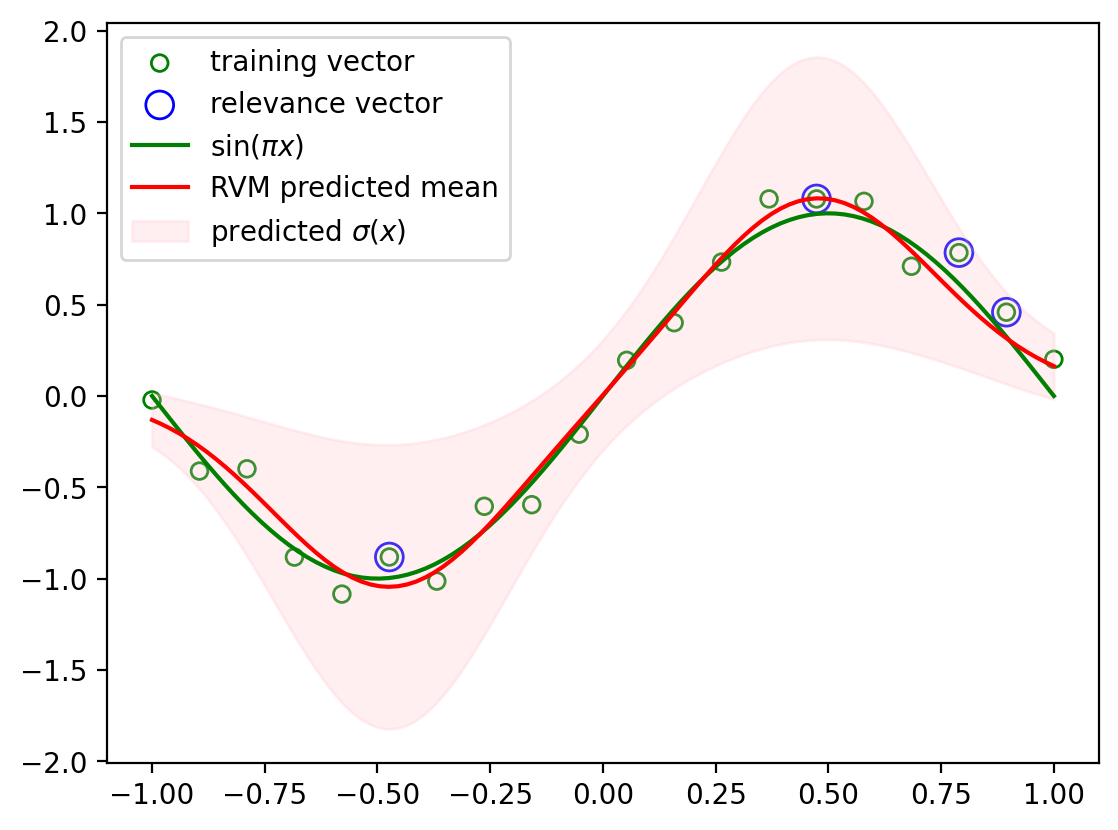

In [130]:
x_space = np.linspace(-1, 1, 100)
t_space = np.sin(np.pi * x_space)

x, t = generate_toy_data(lambda x: np.sin(np.pi * x), 20, 0.2, domain=(-1, 1))

model = RelevanceVectorRegressor(kernel=RBF(theta=np.array([15.0])))
model.fit(x, t)
print(f"Found {model.n_relevance_vectors} relevance vectors.")

mean, variance = model.predict(x_space)

plt.scatter(x, t, facecolor="none", edgecolor="green", label="training vector")
plt.scatter(
    model.relevance_vectors, model.relevance_labels, s=100, facecolor="none", edgecolor="blue", label="relevance vector"
)
plt.plot(x_space, t_space, color="green", label="$\sin(\pi x)$")
plt.plot(x_space, mean, color="red", label="RVM predicted mean")
plt.fill_between(x_space, mean - variance, mean + variance, alpha=0.25, color="pink", label="predicted $\sigma(x)$")
plt.legend()
plt.show()

For many regression and classification tasks, the RVM is found to give models that are typically an order of magnitude more compact than the corresponding support vector machine, resulting in a significant improvement in the speed of processing on test data. Remarkably, the greater sparsity is achieved with little or no reduction in generalization error. The principal disadvantage of the RVM compared to the SVM is that training involves optimizing a non-convex function, and training times can be longer than for a comparable SVM. 

For a model having $M$ basis functions, the RVM requires inversion of a matrix of size $M \times M$, which in general requires $O(M^3)$ computation. In the specific case of the kernel-based SVM model, we have $M = N + 1$. Moreover, there are techniques for training SVMs whose cost is roughly quadratic in $N$. More significantly, in the relevance vector machine the parameters governing complexity and noise variance are determined automatically from a single training run, whereas in the support vector machine the parameters $C$ and $\epsilon$ (or $\nu$) are generally found using cross-validation.

### 7.2.3 RVM for classification

The relevance vector machine framework can be extended to classification problems by applying the automatic relevance determination (ARD) prior over weights to a probabilistic linear classification model, as the one presented in [Chapter 4](ch4_linear_models_for_classification.ipynb),

$$
y(\mathbf{x}, \mathbf{w}) = \sigma(\mathbf{w}^T\boldsymbol\phi(\mathbf{x}))
$$

To that end, we introduce a Gaussian prior over the weight vector $\mathbf{w}$, having separate precision hyperparameter $\alpha_i$ for each weight parameter. However, similar to logistic regression, we can no longer integrate analytically over the parameter vector, and therefore, similar to Bayesian logistic regression, we employ the Laplace approximation. For a given value of $\boldsymbol\alpha$, we build a Gaussian approximation for the posterior distribution of the parameters and thereby obtain an approximation to the marginal likelihood. Maximization of this approximate marginal likelihood allows us to obtain re-estimated values for $\boldsymbol\alpha$.

The posterior distribution over the parameters is obtained by,

$$
p(\mathbf{w}|\mathsf{t},\mathbf{X},\boldsymbol\alpha) = p(\mathsf{t}|\mathbf{w},\mathbf{X})p(\mathbf{w}|\mathbf{0},\boldsymbol\alpha^{-1}\mathbf{I})
$$

Then, the mode of the posterior distribution is obtained by maximizing,

$$
\begin{aligned}
\ln p(\mathbf{w}|\mathsf{t},\mathbf{X},\boldsymbol\alpha) &= \ln p(\mathsf{t}|\mathbf{w},\mathbf{X}) + \ln p(\mathbf{w}|\mathbf{0},\boldsymbol\alpha^{-1}\mathbf{I}) \\
&= \ln \Bigg(\prod_{n=1}^N y_n^{t_n}(1 - y_n)^{1 - t_n}\Bigg) + \ln \Bigg(\frac{1}{(2\pi)^{M/2}|\mathbf{A}^{-1}|^{1/2}} \exp\Big\{ -\frac{1}{2}\mathbf{w}^T\mathbf{A}\mathbf{w} \Big\}\Bigg) \\
&= \sum_{n=1}^N \Big\{ t_n\ln y_n + (1 - t_n)\ln(1 - y_n) \Big\} -\frac{1}{2}\mathbf{w}^T\mathbf{A}\mathbf{w} + \ln \Bigg( \frac{1}{(2\pi)^{M/2}|\mathbf{A}^{-1}|^{1/2}} \Bigg) \\
&= \sum_{n=1}^N \Big\{ t_n\ln y_n + (1 - t_n)\ln(1 - y_n) \Big\} -\frac{1}{2}\mathbf{w}^T\mathbf{A}\mathbf{w} - \frac{M}{2}\ln(2\pi) - \frac{1}{2}\ln|\mathbf{A}^{-1}|
\end{aligned}
$$

where $\mathbf{A} = diag(\alpha_i)$. The maximization can be achieved using iterative reweighted least squares (IRLS). Therefore, the gradient vector and Hessian matrix of the log posterior distribution are given by,

$$
\begin{aligned}
\nabla \ln p(\mathbf{w}|\mathsf{t},\mathbf{X},\boldsymbol\alpha) 
&= \nabla_{\mathbf{w}} \Bigg[ \sum_{n=1}^N \Big\{ t_n\ln y_n + (1 - t_n)\ln(1 - y_n) \Big\} -\frac{1}{2}\mathbf{w}^T\mathbf{A}\mathbf{w} \Bigg] \\
&= \sum_{n=1}^N \nabla_{\mathbf{w}} \Big\{ t_n\ln y_n + (1 - t_n)\ln(1 - y_n) \Big\} - \nabla_{\mathbf{w}}\frac{1}{2}\mathbf{w}^T\mathbf{A}\mathbf{w} \\
&= \sum_{n=1}^N \nabla_{\mathbf{w}} \Big\{ t_n\ln y_n + (1 - t_n)\ln(1 - y_n) \Big\} - \mathbf{A}\mathbf{w} \\
&\overset{(4.88)}{=} \sum_{n=1}^N \Big\{ t_n\frac{1}{y_n}y_n(1 - y_n)\boldsymbol\phi_n - (1 - t_n)\frac{1}{1 - y_n}y_n(1 - y_n)\boldsymbol\phi_n \Big\} - \mathbf{A}\mathbf{w} \\
&= \sum_{n=1}^N \Big\{ t_n(1 - y_n)\boldsymbol\phi_n - (1 - t_n)y_n\boldsymbol\phi_n \Big\} - \mathbf{A}\mathbf{w} \\
&= \sum_{n=1}^N \Big\{ t_n\boldsymbol\phi_n - t_n y_n\boldsymbol\phi_n - y_n\boldsymbol\phi_n + t_n y_n\boldsymbol\phi_n \Big\} - \mathbf{A}\mathbf{w} \\
&= \sum_{n=1}^N (t_n - y_n)\boldsymbol\phi_n - \mathbf{A}\mathbf{w}
\end{aligned}
$$

and

$$
\begin{aligned}
\nabla\nabla \ln p(\mathbf{w}|\mathsf{t},\mathbf{X},\boldsymbol\alpha) 
&= \nabla_{\mathbf{w}} \Bigg[ \sum_{n=1}^N (t_n - y_n)\boldsymbol\phi_n - \mathbf{A}\mathbf{w} \Bigg] \\
&= \sum_{n=1}^N \nabla_{\mathbf{w}}\{(t_n - y_n)\boldsymbol\phi_n\} - \nabla_{\mathbf{w}}\mathbf{A}\mathbf{w} \\
&= \sum_{n=1}^N \nabla_{\mathbf{w}}\{(t_n - y_n)\boldsymbol\phi_n\} - \mathbf{A} \\
&= -\sum_{n=1}^N \nabla_{\mathbf{w}}y_n\boldsymbol\phi_n - \mathbf{A} \\
&\overset{(4.88)}{=} -\sum_{n=1}^N y_n(1 - y_n)\boldsymbol\phi_n\boldsymbol\phi_n^T - \mathbf{A} \\
&= -(\boldsymbol\Phi^T \mathbf{B} \boldsymbol\Phi + \mathbf{A}) \\
\end{aligned}
$$

where $\mathbf{B}$ is a diagonal matrix having elements $b_n = y_n(1 - y_n)$.

The elements of the negative Hessian can be interpreted as the inverse covariance matrix for the Gaussian approximation to the posterior distribution. The mode of the resulting approximation to the posterior distribution is obtained by setting the gradient vector to zero, giving the mean and covariance of the Laplace approximation in the form,

$$
\begin{aligned}
\mathbf{w}^\star &= \mathbf{A}^{-1}\boldsymbol\Phi^T(\mathsf{t} - \mathbf{y}) \\
\mathbf{\Sigma} &= (\boldsymbol\Phi^T \mathbf{B} \boldsymbol\Phi + \mathbf{A})^{-1}
\end{aligned}
$$

Then, we can use the Laplace approximation of the posterior to evaluate the marginal likelihood. Using the general result $(4.135)$ for an integral evaluated using the Laplace approximation, we have

$$
\begin{aligned}
p(\mathsf{t}|\mathbf{X}, \boldsymbol\alpha) &= \int p(\mathsf{t}|\mathbf{w}, \mathbf{X}) p(\mathbf{w}|\boldsymbol\alpha) d\mathbf{w} \\
&\approx p(\mathsf{t}|\mathbf{w}^\star, \mathbf{X}) p(\mathbf{w}^\star|\boldsymbol\alpha) (2\pi)^{M/2}|\mathbf{\Sigma}|^{1/2} \\
&= \prod_{n=1}^N p(t_n|\mathbf{w}^\star, \mathbf{x}_n) \prod_{n=1}^N \mathcal{N}(w_i^\star|0, \alpha_i) (2\pi)^{M/2}|\mathbf{\Sigma}|^{1/2} \\
&= \prod_{n=1}^N p(t_n|\mathbf{w}^\star, \mathbf{x}_n) \mathcal{N}(\mathbf{w}^\star|\mathbf{0}, \mathbf{A}) (2\pi)^{M/2}|\mathbf{\Sigma}|^{1/2}
\end{aligned}
$$

Taking the logarithm of the marginal likelihood, we obtain,

$$
\begin{aligned}
\ln p(\mathsf{t}|\mathbf{X}, \boldsymbol\alpha) 
&= \ln \Bigg( \prod_{n=1}^N y_n^{t_n}(1 - y_n)^{1 - t_n} \Bigg) + \ln\mathcal{N}(\mathbf{w}^\star|\mathbf{0}, \mathbf{A}) + \ln \Big( (2\pi)^{M/2}|\mathbf{\Sigma}|^{1/2} \Big) \\
&= \ln \Bigg( \prod_{n=1}^N y_n^{t_n}(1 - y_n)^{1 - t_n} \Bigg) 
- \frac{1}{2}(\mathbf{w}^\star)^T\mathbf{A}\mathbf{w}^\star - \frac{1}{2}\ln|\mathbf{A}| - \frac{M}{2}\ln(2\pi) + \frac{M}{2}\ln(2\pi) + \frac{1}{2}\ln|\mathbf{\Sigma}| \\
&= \ln \Bigg( \prod_{n=1}^N y_n^{t_n}(1 - y_n)^{1 - t_n} \Bigg) - \frac{1}{2}(\mathbf{w}^\star)^T\mathbf{A}\mathbf{w}^\star - \frac{1}{2}\ln|\mathbf{A}| + \frac{1}{2}\ln|\mathbf{\Sigma}| \\
&=  \prod_{n=1}^N \Big\{ t_n\ln y_n + (1 - t_n)\ln(1 - y_n) \Big\} - \frac{1}{2}(\mathbf{w}^\star)^T\mathbf{A}\mathbf{w}^\star - \frac{1}{2}\ln|\mathbf{A}| + \frac{1}{2}\ln|\mathbf{\Sigma}|
\end{aligned}
$$

Then, setting the derivative of the marginal likelihood with respect to $\alpha_i$ equal to zero, we obtain,

$$
\begin{aligned}
\frac{\partial \ln p(\mathsf{t}|\mathbf{X}, \boldsymbol\alpha) }{\partial\alpha_i} = 0 &\Leftrightarrow 
\frac{\partial}{\partial\alpha_i} \prod_{n=1}^N \Big\{ t_n\ln y_n + (1 - t_n)\ln(1 - y_n) \Big\} - \frac{1}{2}\frac{\partial}{\partial\alpha_i}(\mathbf{w}^\star)^T\mathbf{A}\mathbf{w}^\star - \frac{1}{2}\frac{\partial}{\partial\alpha_i}\ln|\mathbf{A}| + \frac{1}{2}\frac{\partial}{\partial\alpha_i}\ln|\mathbf{\Sigma}| = 0\\
&\Leftrightarrow - \frac{1}{2}\frac{\partial}{\partial\alpha_i}(\mathbf{w}^\star)^T\mathbf{A}\mathbf{w}^\star - \frac{1}{2}\frac{\partial}{\partial\alpha_i}\ln|\mathbf{A}| + \frac{1}{2}\frac{\partial}{\partial\alpha_i}\ln|\mathbf{\Sigma}| = 0\\
&\Leftrightarrow - \frac{1}{2}(w_i^\star)^2 - \frac{1}{2}\frac{\partial}{\partial\alpha_i}\ln|\mathbf{A}| + \frac{1}{2}\frac{\partial}{\partial\alpha_i}\ln|\mathbf{\Sigma}| = 0\\
&\Leftrightarrow - \frac{1}{2}(w_i^\star)^2 + \frac{1}{2\alpha_i} - \frac{1}{2}\Sigma_{ii} = 0 \\
&\Leftrightarrow - (w_i^\star)^2 + \frac{1}{\alpha_i} - \Sigma_{ii} = 0 \\
&\Leftrightarrow - \alpha_i(w_i^\star)^2 + 1 - \alpha_i\Sigma_{ii} = 0 \\
&\Leftrightarrow 1 - \alpha_i\Sigma_{ii} = \alpha_i(w_i^\star)^2 \\
&\Leftrightarrow \alpha_i^{new} = \frac{1 - \alpha_i\Sigma_{ii}}{(w_i^\star)^2}
\end{aligned}
$$

which is identical to the re-estimation formula obtained for the regression case.